# 1. Load Library

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

Using TensorFlow backend.


# 2. Data

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 500
LATENT_DIM = 25

In [4]:
input_texts = []
target_texts = []
for line in open('./robert_frost.txt', encoding='utf-8'):
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos> ' + line
    target_line= line + ' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)

all_lines = input_texts + target_texts

In [5]:
print(len(input_texts), len(target_texts), len(all_lines))

1436 1436 2872


In [6]:
# convert sentences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [7]:
# find max seq length
max_sequnce_length_from_data = max(len(s) for s in input_sequences)
print("Max sequence length: ", max_sequnce_length_from_data)

Max sequence length:  12


In [8]:
# get_word -> integer mapping
word2idx = tokenizer.word_index
print("Found %s unique tokens." % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [9]:
# pad sequences so that wee get a N x T matrix
max_sequence_length = min(max_sequnce_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print("Shape of data tensor: ", input_sequences.shape)

Shape of data tensor:  (1436, 12)


In [10]:
# load in pre-trained word vectors
print("Loading word vectors...")
word2vec = {}

with open(os.path.join('./glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
print("Found %s word vectors." % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [11]:
# prepare embedding matrix
print("filling pre-trained embeddings")
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

filling pre-trained embeddings


In [12]:
print(len(input_sequences), max_sequence_length, num_words)

1436 12 3000


In [13]:
# one_hot_targets
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

# 3. Model

In [14]:
# load pre-trained embeddings into Embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])

In [15]:
# build a model
input_ = Input(shape=(max_sequence_length,)) # encoder
initial_h = Input(shape=(LATENT_DIM,)) # hidden_state
initial_c = Input(shape=(LATENT_DIM,)) # cell_state
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_state=True, return_sequences=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

# 학습만 하고 출력은 안할 것이다.
model = Model([input_, initial_h, initial_c], output)

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 100)      300000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [17]:
from keras.callbacks import EarlyStopping

In [18]:
# compile
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [19]:
# training
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size = BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    #callbacks=callback_list
)

Train on 1148 samples, validate on 288 samples
Epoch 1/500
1148/1148 [==============================] - 2s 2ms/step - loss: 5.4038 - acc: 0.0543 - val_loss: 5.0868 - val_acc: 0.0095
Epoch 2/500
1148/1148 [==============================] - 1s 666us/step - loss: 4.6417 - acc: 0.0306 - val_loss: 4.7954 - val_acc: 0.0833
Epoch 3/500
1148/1148 [==============================] - 1s 682us/step - loss: 4.3444 - acc: 0.0833 - val_loss: 4.9071 - val_acc: 0.0833
Epoch 4/500
1148/1148 [==============================] - 1s 681us/step - loss: 4.3007 - acc: 0.0833 - val_loss: 4.9262 - val_acc: 0.0833
Epoch 5/500
1148/1148 [==============================] - 1s 704us/step - loss: 4.2493 - acc: 0.0833 - val_loss: 4.9741 - val_acc: 0.0833
Epoch 6/500
1148/1148 [==============================] - 1s 712us/step - loss: 4.2192 - acc: 0.0833 - val_loss: 4.9878 - val_acc: 0.0833
Epoch 7/500
1148/1148 [==============================] - 1s 704us/step - loss: 4.1889 - acc: 0.0833 - val_loss: 5.0007 - val_acc: 0.0

1148/1148 [==============================] - 1s 694us/step - loss: 2.0690 - acc: 0.2808 - val_loss: 5.7822 - val_acc: 0.0738
Epoch 120/500
1148/1148 [==============================] - 1s 683us/step - loss: 2.0608 - acc: 0.2807 - val_loss: 5.7886 - val_acc: 0.0735
Epoch 121/500
1148/1148 [==============================] - 1s 684us/step - loss: 2.0525 - acc: 0.2832 - val_loss: 5.7983 - val_acc: 0.0735
Epoch 122/500
1148/1148 [==============================] - 1s 680us/step - loss: 2.0431 - acc: 0.2848 - val_loss: 5.7984 - val_acc: 0.0755
Epoch 123/500
1148/1148 [==============================] - 1s 677us/step - loss: 2.0379 - acc: 0.2848 - val_loss: 5.8000 - val_acc: 0.0738
Epoch 124/500
1148/1148 [==============================] - 1s 696us/step - loss: 2.0304 - acc: 0.2862 - val_loss: 5.8205 - val_acc: 0.0738
Epoch 125/500
1148/1148 [==============================] - 1s 699us/step - loss: 2.0238 - acc: 0.2865 - val_loss: 5.8182 - val_acc: 0.0741
Epoch 126/500
1148/1148 [================

1148/1148 [==============================] - 1s 697us/step - loss: 1.7417 - acc: 0.3340 - val_loss: 6.1597 - val_acc: 0.0668
Epoch 179/500
1148/1148 [==============================] - 1s 756us/step - loss: 1.7368 - acc: 0.3330 - val_loss: 6.1612 - val_acc: 0.0686
Epoch 180/500
1148/1148 [==============================] - 1s 755us/step - loss: 1.7340 - acc: 0.3336 - val_loss: 6.1653 - val_acc: 0.0668
Epoch 181/500
1148/1148 [==============================] - 1s 711us/step - loss: 1.7322 - acc: 0.3340 - val_loss: 6.1761 - val_acc: 0.0668
Epoch 182/500
1148/1148 [==============================] - 1s 688us/step - loss: 1.7282 - acc: 0.3349 - val_loss: 6.1639 - val_acc: 0.0694
Epoch 183/500
1148/1148 [==============================] - 1s 703us/step - loss: 1.7228 - acc: 0.3372 - val_loss: 6.1885 - val_acc: 0.0674
Epoch 184/500
1148/1148 [==============================] - 1s 710us/step - loss: 1.7200 - acc: 0.3351 - val_loss: 6.1871 - val_acc: 0.0683
Epoch 185/500
1148/1148 [================

Epoch 295/500
1148/1148 [==============================] - 1s 681us/step - loss: 1.4058 - acc: 0.3944 - val_loss: 6.6754 - val_acc: 0.0628
Epoch 296/500
1148/1148 [==============================] - 1s 682us/step - loss: 1.4036 - acc: 0.3948 - val_loss: 6.6988 - val_acc: 0.0622
Epoch 297/500
1148/1148 [==============================] - 1s 684us/step - loss: 1.3988 - acc: 0.3954 - val_loss: 6.6896 - val_acc: 0.0602
Epoch 298/500
1148/1148 [==============================] - 1s 688us/step - loss: 1.3982 - acc: 0.3955 - val_loss: 6.7024 - val_acc: 0.0634
Epoch 299/500
1148/1148 [==============================] - 1s 701us/step - loss: 1.3996 - acc: 0.3942 - val_loss: 6.6982 - val_acc: 0.0613
Epoch 300/500
1148/1148 [==============================] - 1s 699us/step - loss: 1.3993 - acc: 0.3958 - val_loss: 6.6984 - val_acc: 0.0651
Epoch 301/500
1148/1148 [==============================] - 1s 698us/step - loss: 1.3949 - acc: 0.3938 - val_loss: 6.7318 - val_acc: 0.0608
Epoch 302/500
1148/1148 [==

Epoch 354/500
1148/1148 [==============================] - 1s 685us/step - loss: 1.3073 - acc: 0.4141 - val_loss: 6.8964 - val_acc: 0.0582
Epoch 355/500
1148/1148 [==============================] - 1s 677us/step - loss: 1.3041 - acc: 0.4149 - val_loss: 6.8784 - val_acc: 0.0590
Epoch 356/500
1148/1148 [==============================] - 1s 670us/step - loss: 1.3017 - acc: 0.4133 - val_loss: 6.8934 - val_acc: 0.0611
Epoch 357/500
1148/1148 [==============================] - 1s 677us/step - loss: 1.2998 - acc: 0.4141 - val_loss: 6.8865 - val_acc: 0.0622
Epoch 358/500
1148/1148 [==============================] - 1s 693us/step - loss: 1.2952 - acc: 0.4152 - val_loss: 6.8956 - val_acc: 0.0616
Epoch 359/500
1148/1148 [==============================] - 1s 683us/step - loss: 1.2916 - acc: 0.4166 - val_loss: 6.9030 - val_acc: 0.0616
Epoch 360/500
1148/1148 [==============================] - 1s 676us/step - loss: 1.2908 - acc: 0.4182 - val_loss: 6.9028 - val_acc: 0.0628
Epoch 361/500
1148/1148 [==

Epoch 413/500
1148/1148 [==============================] - 1s 678us/step - loss: 1.2203 - acc: 0.4325 - val_loss: 7.0848 - val_acc: 0.0587
Epoch 414/500
1148/1148 [==============================] - 1s 681us/step - loss: 1.2182 - acc: 0.4337 - val_loss: 7.0798 - val_acc: 0.0579
Epoch 415/500
1148/1148 [==============================] - 1s 685us/step - loss: 1.2215 - acc: 0.4310 - val_loss: 7.0866 - val_acc: 0.0576
Epoch 416/500
1148/1148 [==============================] - 1s 680us/step - loss: 1.2228 - acc: 0.4311 - val_loss: 7.0940 - val_acc: 0.0587
Epoch 417/500
1148/1148 [==============================] - 1s 684us/step - loss: 1.2238 - acc: 0.4318 - val_loss: 7.0895 - val_acc: 0.0564
Epoch 418/500
1148/1148 [==============================] - 1s 681us/step - loss: 1.2231 - acc: 0.4299 - val_loss: 7.0911 - val_acc: 0.0593
Epoch 419/500
1148/1148 [==============================] - 2s 2ms/step - loss: 1.2231 - acc: 0.4284 - val_loss: 7.0713 - val_acc: 0.0576
Epoch 420/500
1148/1148 [====

Epoch 472/500
1148/1148 [==============================] - 1s 683us/step - loss: 1.1514 - acc: 0.4456 - val_loss: 7.2428 - val_acc: 0.0587
Epoch 473/500
1148/1148 [==============================] - 1s 681us/step - loss: 1.1519 - acc: 0.4464 - val_loss: 7.2359 - val_acc: 0.0538
Epoch 474/500
1148/1148 [==============================] - 1s 678us/step - loss: 1.1519 - acc: 0.4481 - val_loss: 7.2340 - val_acc: 0.0556
Epoch 475/500
1148/1148 [==============================] - 1s 679us/step - loss: 1.1487 - acc: 0.4476 - val_loss: 7.2445 - val_acc: 0.0567
Epoch 476/500
1148/1148 [==============================] - 1s 676us/step - loss: 1.1488 - acc: 0.4483 - val_loss: 7.2370 - val_acc: 0.0550
Epoch 477/500
1148/1148 [==============================] - 1s 711us/step - loss: 1.1523 - acc: 0.4467 - val_loss: 7.2448 - val_acc: 0.0558
Epoch 478/500
1148/1148 [==============================] - 1s 685us/step - loss: 1.1491 - acc: 0.4474 - val_loss: 7.2627 - val_acc: 0.0576
Epoch 479/500
1148/1148 [==

# 4. Result

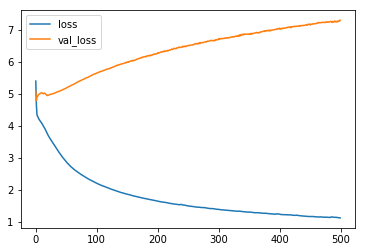

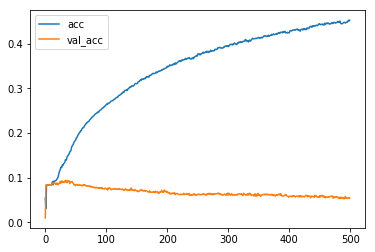

In [20]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# 5. Sample

In [21]:
# make a sampling model
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)

# hidden, cell 을 출력할 것이다. 다시 input으로 들어가야 하므로
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [22]:
sampling_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             300000      input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
lstm_1 (LS

- input으로 들어가는 것이 sequence_length = 1이 되었다. 그래도 output shape은 똑같다. 


In [23]:
def sample_line():
    np_input = np.array([[word2idx['<sos>']]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))
                    
    eos = word2idx['<eos>']
    
    output_sentence = []
    
    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])
        probs = o[0, 0]
        
        # 아무것도 아닐 때 - padding
        if np.argmax(probs) == 0:
            print('wtf')
            
        # recalculate
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        
        if idx == eos:
            break
            
        output_sentence.append(idx2word.get(idx, '<WTF %s>'% idx))
        np_input[0, 0] = idx
    return ' '.join(output_sentence)


In [24]:
idx2word = {v:k for k, v in word2idx.items()}

In [25]:
for _ in range(4):
    print(sample_line())

i went whose piano's fur.
the poetess had is nailed.
'she should, shouldn't she, you're so many times
so far do it that are what i don't we don't care
